<a href="https://colab.research.google.com/github/TheCaveOfAdullam/study2/blob/main/pruningResnet50_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow-model-optimization

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import (confusion_matrix, classification_report, f1_score,
                             precision_score, recall_score, roc_curve, roc_auc_score)
import matplotlib.pyplot as plt
import time
import os
import tracemalloc  # Memory usage measurement
import tensorflow_model_optimization as tfmot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 6.4 MB/s eta 0:00:00


In [3]:
# Define paths
train_dir = '/content/drive/MyDrive/motor_data/train'
validation_dir = '/content/drive/MyDrive/motor_data/validation'
test_dir = '/content/drive/MyDrive/motor_data/test'

# Set image size and batch size
image_size = (224, 224)
batch_size = 32

# Load datasets
train_dataset = image_dataset_from_directory(train_dir, image_size=image_size, batch_size=batch_size, label_mode='int')
validation_dataset = image_dataset_from_directory(validation_dir, image_size=image_size, batch_size=batch_size, label_mode='int')
test_dataset = image_dataset_from_directory(test_dir, image_size=image_size, batch_size=batch_size, label_mode='int')

Found 12004 files belonging to 4 classes.
Found 4000 files belonging to 4 classes.
Found 4004 files belonging to 4 classes.


In [4]:
# Load ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add new top layers
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes: normal, fault_BB, fault_SM, fault_RI
])

# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

94765736/94765736 [==============================] - 5s 0us/step


In [5]:
# Train the model
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=10, callbacks=[reduce_lr])

Epoch 1/10
376/376 [==============================] - 5062s 13s/step - loss: 0.0145 - accuracy: 0.9953 - val_loss: 3.6728e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/10
376/376 [==============================] - 251s 660ms/step - loss: 0.0018 - accuracy: 0.9999 - val_loss: 18.9823 - val_accuracy: 0.3260 - lr: 0.0010
Epoch 3/10
376/376 [==============================] - 247s 650ms/step - loss: 0.0818 - accuracy: 0.9932 - val_loss: 1.7425e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/10
376/376 [==============================] - 250s 656ms/step - loss: 1.8505e-04 - accuracy: 0.9999 - val_loss: 1.1099e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/10
376/376 [==============================] - 245s 645ms/step - loss: 2.3817e-05 - accuracy: 1.0000 - val_loss: 1.1067e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/10
376/376 [==============================] - 273s 718ms/step - loss: 0.0024 - accuracy: 0.9998 - val_loss: 1.1552e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/10
376/376

In [6]:
# Initial evaluation
val_loss, val_acc = model.evaluate(validation_dataset)
print(f"Initial Validation Loss: {val_loss}")
print(f"Initial Validation Accuracy: {val_acc}")

125/125 [==============================] - 50s 378ms/step - loss: 2.6023e-05 - accuracy: 1.0000
Initial Validation Loss: 2.6022509700851515e-05
Initial Validation Accuracy: 1.0


In [7]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Initial Test Loss: {test_loss}")
print(f"Initial Test Accuracy: {test_acc}")

126/126 [==============================] - 1598s 12s/step - loss: 5.5511e-06 - accuracy: 1.0000
Initial Test Loss: 5.551130016101524e-06
Initial Test Accuracy: 1.0


In [8]:
# Save initial model and measure size
model.save('original_motor_fault_classification_model.h5')
original_model_size = os.path.getsize('original_motor_fault_classification_model.h5')
print(f"Original Model Size: {original_model_size / (1024 * 1024):.2f} MB")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Original Model Size: 282.31 MB


In [9]:
# Measure initial inference time and memory usage
start_time = time.time()
tracemalloc.start()
y_true, y_pred = [], []
for batch in test_dataset:
    images, labels = batch
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
original_inference_time = end_time - start_time
original_peak_memory = peak / (1024 * 1024)
print(f"Original Inference Time: {original_inference_time:.2f} seconds")
print(f"Original Peak Memory Usage: {original_peak_memory:.2f} MB")

1/1 [==============================] - 2s 2s/step
Original Inference Time: 74.43 seconds
Original Peak Memory Usage: 5.83 MB


In [10]:
# Initial model evaluation metrics
conf_matrix_original = confusion_matrix(y_true, y_pred)
print("Confusion Matrix (Original):")
print(conf_matrix_original)

print("Classification Report (Original):")
print(classification_report(y_true, y_pred, target_names=['normal', 'fault_BB', 'fault_SM', 'fault_RI']))

Confusion Matrix (Original):
[[1004    0    0    0]
 [   0 1000    0    0]
 [   0    0 1000    0]
 [   0    0    0 1000]]
Classification Report (Original):
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      1004
    fault_BB       1.00      1.00      1.00      1000
    fault_SM       1.00      1.00      1.00      1000
    fault_RI       1.00      1.00      1.00      1000

    accuracy                           1.00      4004
   macro avg       1.00      1.00      1.00      4004
weighted avg       1.00      1.00      1.00      4004



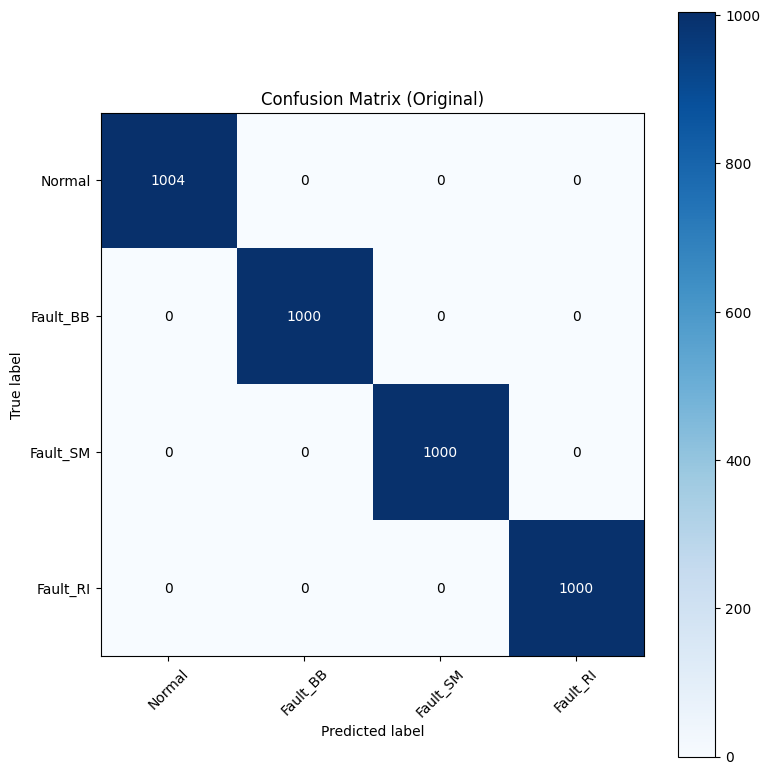

In [11]:
# Visualize initial confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix_original, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Original)')
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, ['Normal', 'Fault_BB', 'Fault_SM', 'Fault_RI'], rotation=45)
plt.yticks(tick_marks, ['Normal', 'Fault_BB', 'Fault_SM', 'Fault_RI'])

fmt = 'd'
thresh = conf_matrix_original.max() / 2.
for i, j in np.ndindex(conf_matrix_original.shape):
    plt.text(j, i, format(conf_matrix_original[i, j], fmt),
             ha="center", va="center",
             color="white" if conf_matrix_original[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [12]:
# Calculate additional initial metrics
f1_original = f1_score(y_true, y_pred, average='weighted')
precision_original = precision_score(y_true, y_pred, average='weighted')
recall_original = recall_score(y_true, y_pred, average='weighted')

print(f"Original F1 Score: {f1_original:.2f}")
print(f"Original Precision: {precision_original:.2f}")
print(f"Original Recall: {recall_original:.2f}")

Original F1 Score: 1.00
Original Precision: 1.00
Original Recall: 1.00


In [13]:
# ROC curve and AUC calculation (original model)
y_true_binary = tf.keras.utils.to_categorical(y_true, num_classes=4)
y_pred_binary = tf.keras.utils.to_categorical(y_pred, num_classes=4)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = roc_auc_score(y_true_binary[:, i], y_pred_binary[:, i])

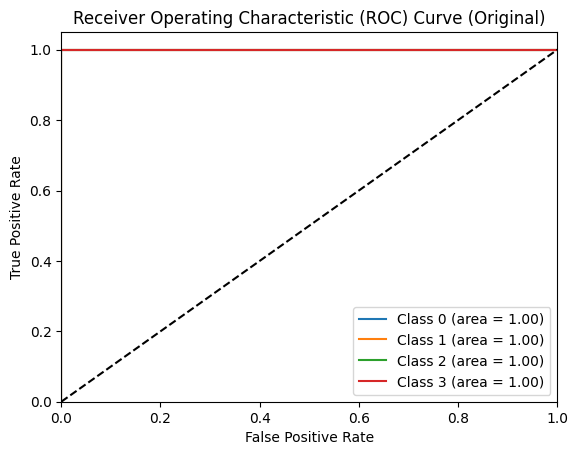

In [14]:
# Visualize ROC curve (original model)
plt.figure()
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Original)')
plt.legend(loc='lower right')
plt.show()

In [15]:
# Define pruning parameters and apply pruning with 70% final sparsity
pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(
    initial_sparsity=0.0,
    final_sparsity=0.5,
    begin_step=0,
    end_step=np.ceil(len(train_dataset) / batch_size).astype(np.int32) * 10
)

pruned_model = tfmot.sparsity.keras.prune_low_magnitude(
    model,
    pruning_schedule=pruning_schedule
)

pruned_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

In [16]:
# Train pruned model
callbacks = [reduce_lr, tfmot.sparsity.keras.UpdatePruningStep()]
history_pruned = pruned_model.fit(train_dataset, validation_data=validation_dataset, epochs=10, callbacks=callbacks)

Epoch 1/10
376/376 [==============================] - 348s 726ms/step - loss: 0.0256 - accuracy: 0.9978 - val_loss: 4.5537e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/10
376/376 [==============================] - 264s 691ms/step - loss: 9.9159e-04 - accuracy: 0.9999 - val_loss: 3.0834e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/10
376/376 [==============================] - 293s 766ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 1.0379e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/10
376/376 [==============================] - 291s 766ms/step - loss: 0.0064 - accuracy: 0.9998 - val_loss: 3.3563e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/10
376/376 [==============================] - 268s 703ms/step - loss: 0.0168 - accuracy: 0.9983 - val_loss: 0.1604 - val_accuracy: 0.9808 - lr: 0.0010
Epoch 6/10
376/376 [==============================] - 267s 702ms/step - loss: 0.0054 - accuracy: 0.9995 - val_loss: 1.7907e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/10
376/376 [==

In [17]:
# Evaluate pruned model
val_loss, val_acc = pruned_model.evaluate(validation_dataset)
print(f"Pruned Validation Loss: {val_loss}")
print(f"Pruned Validation Accuracy: {val_acc}")

125/125 [==============================] - 52s 395ms/step - loss: 1.2792e-05 - accuracy: 1.0000
Pruned Validation Loss: 1.2791744666174054e-05
Pruned Validation Accuracy: 1.0


In [18]:
test_loss, test_acc = pruned_model.evaluate(test_dataset)
print(f"Pruned Test Loss: {test_loss}")
print(f"Pruned Test Accuracy: {test_acc}")

126/126 [==============================] - 55s 414ms/step - loss: 5.2191e-05 - accuracy: 1.0000
Pruned Test Loss: 5.21910005772952e-05
Pruned Test Accuracy: 1.0


In [19]:
# Save pruned model
model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model)
model_for_export.save('pruned_motor_fault_classification_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
# Quantize the model
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [21]:
# Save quantized model
with open('quantized_motor_fault_classification_model.tflite', 'wb') as f:
    f.write(tflite_model)

In [22]:
# Measure quantized model size
quantized_model_size = os.path.getsize('quantized_motor_fault_classification_model.tflite')
print(f"Quantized Model Size: {quantized_model_size / (1024 * 1024):.2f} MB")

Quantized Model Size: 23.83 MB


In [23]:
# Measure inference time and memory usage for pruned and quantized model using TFLite
interpreter = tf.lite.Interpreter(model_path='quantized_motor_fault_classification_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [24]:
# Preprocess input
def preprocess_image(image):
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32)
    image = image / 255.0  # Normalize to [0, 1]
    return image

start_time = time.time()
tracemalloc.start()
y_true_quantized, y_pred_quantized = [], []
for batch in test_dataset:
    images, labels = batch
    y_true_quantized.extend(labels.numpy())
    for image in images:
        preprocessed_image = preprocess_image(image).numpy()
        preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
        interpreter.set_tensor(input_details[0]['index'], preprocessed_image)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        y_pred_quantized.append(np.argmax(output_data))

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
quantized_inference_time = end_time - start_time
quantized_peak_memory = peak / (1024 * 1024)
print(f"Quantized Inference Time: {quantized_inference_time:.2f} seconds")
print(f"Quantized Peak Memory Usage: {quantized_peak_memory:.2f} MB")

Quantized Inference Time: 580.67 seconds
Quantized Peak Memory Usage: 2.82 MB


In [25]:
# Quantized model evaluation metrics
conf_matrix_quantized = confusion_matrix(y_true_quantized, y_pred_quantized)
print("Confusion Matrix (Quantized):")
print(conf_matrix_quantized)

print("Classification Report (Quantized):")
print(classification_report(y_true_quantized, y_pred_quantized, target_names=['normal', 'fault_BB', 'fault_SM', 'fault_RI']))

Confusion Matrix (Quantized):
[[   0 1004    0    0]
 [   0 1000    0    0]
 [   0 1000    0    0]
 [   0 1000    0    0]]
Classification Report (Quantized):
              precision    recall  f1-score   support

      normal       0.00      0.00      0.00      1004
    fault_BB       0.25      1.00      0.40      1000
    fault_SM       0.00      0.00      0.00      1000
    fault_RI       0.00      0.00      0.00      1000

    accuracy                           0.25      4004
   macro avg       0.06      0.25      0.10      4004
weighted avg       0.06      0.25      0.10      4004



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


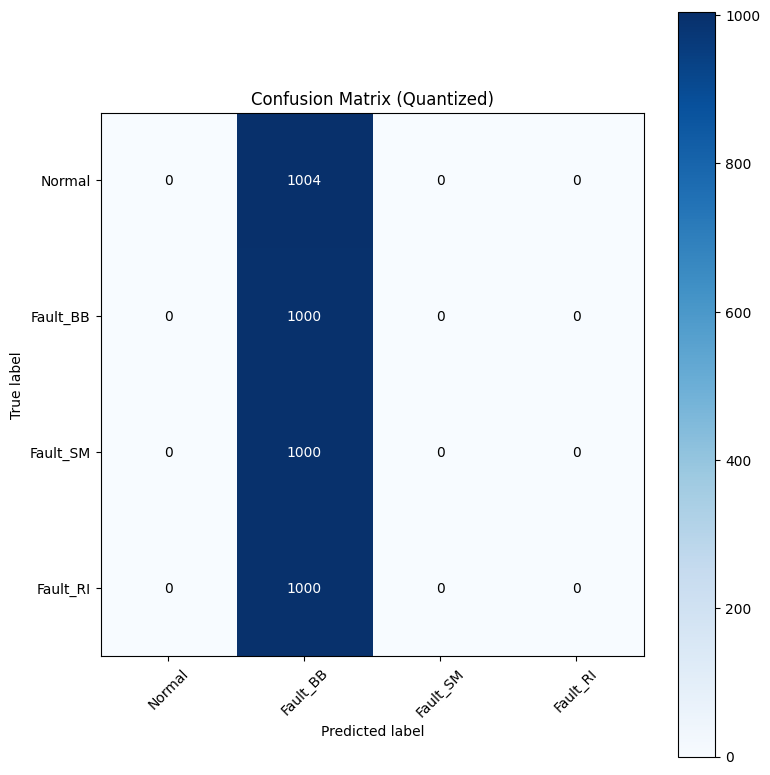

In [26]:
# Visualize quantized confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix_quantized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Quantized)')
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, ['Normal', 'Fault_BB', 'Fault_SM', 'Fault_RI'], rotation=45)
plt.yticks(tick_marks, ['Normal', 'Fault_BB', 'Fault_SM', 'Fault_RI'])

fmt = 'd'
thresh = conf_matrix_quantized.max() / 2.
for i, j in np.ndindex(conf_matrix_quantized.shape):
    plt.text(j, i, format(conf_matrix_quantized[i, j], fmt),
             ha="center", va="center",
             color="white" if conf_matrix_quantized[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [27]:
# Calculate additional quantized metrics
f1_quantized = f1_score(y_true_quantized, y_pred_quantized, average='weighted')
precision_quantized = precision_score(y_true_quantized, y_pred_quantized, average='weighted')
recall_quantized = recall_score(y_true_quantized, y_pred_quantized, average='weighted')

print(f"Quantized F1 Score: {f1_quantized:.2f}")
print(f"Quantized Precision: {precision_quantized:.2f}")
print(f"Quantized Recall: {recall_quantized:.2f}")

Quantized F1 Score: 0.10
Quantized Precision: 0.06
Quantized Recall: 0.25


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
# ROC curve and AUC calculation (quantized model)
y_true_binary_quantized = tf.keras.utils.to_categorical(y_true_quantized, num_classes=4)
y_pred_binary_quantized = tf.keras.utils.to_categorical(y_pred_quantized, num_classes=4)

fpr_quantized, tpr_quantized, roc_auc_quantized = {}, {}, {}
for i in range(4):
    fpr_quantized[i], tpr_quantized[i], _ = roc_curve(y_true_binary_quantized[:, i], y_pred_binary_quantized[:, i])
    roc_auc_quantized[i] = roc_auc_score(y_true_binary_quantized[:, i], y_pred_binary_quantized[:, i])

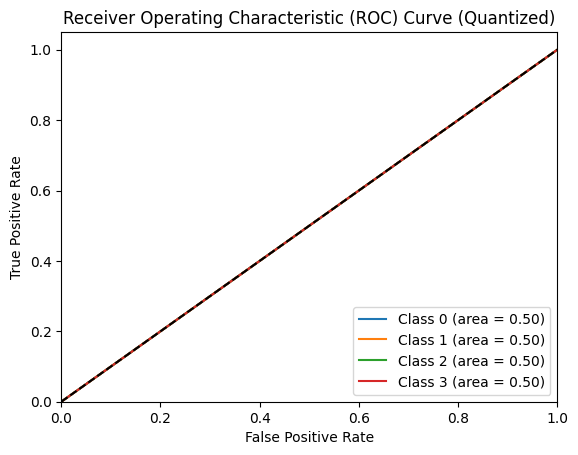

In [29]:
# Visualize ROC curve (quantized model)
plt.figure()
for i in range(4):
    plt.plot(fpr_quantized[i], tpr_quantized[i], label=f'Class {i} (area = {roc_auc_quantized[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Quantized)')
plt.legend(loc='lower right')
plt.show()